# LSTM Sample Implementation

In [1]:
import glob
from models import DataReader
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

print('Tensorflow Version: {}'.format(tf.__version__))

Tensorflow Version: 1.8.0


## Data load

In [26]:
DIR = '/home/miles/PycharmProjects/MultivariateTimeSeries/data/'
dr = DataReader(
    directory=DIR,
    coin='dgb',
    batch_size=100,
    train_size=0.9)
training_batches = dr.get_batch(is_training=True)
testing_batches = dr.get_batch(is_training=False)

# Network Implementation

## Constants

In [27]:
TIME_STEPS = 28
N_INPUT = 5
N_HIDDEN = 128
LEARNING_RATE = 0.001
NUM_UNITS = 28

tf.reset_default_graph()

In [28]:
# Input placeholders
x = tf.placeholder(tf.float32, [None, TIME_STEPS, N_INPUT])
y = tf.placeholder(tf.float32, [None, 1])

In [29]:
out_weights = tf.Variable(tf.random_normal([NUM_UNITS, 1]))
out_bias = tf.Variable(tf.random_normal([1]))

In [30]:
# Reshape the input tensor from [batch_size, timesteps, n_input] to
# "timesteps" of [batch_size, n_input]
unstacked_inputs = tf.unstack(x, TIME_STEPS, 1)

In [31]:
lstm_layer = tf.contrib.rnn.BasicLSTMCell(NUM_UNITS, forget_bias=1)
outputs, _ = tf.contrib.rnn.static_rnn(lstm_layer, unstacked_inputs, dtype=tf.float32) 

In [32]:
predictions = tf.matmul(outputs[-1], out_weights) + out_bias

In [33]:
loss = tf.losses.mean_squared_error(y, predictions)
train_step = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

In [34]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    test_batch = next(testing_batches)

    for step in range(10001):
        train_batch = next(training_batches)
        features = train_batch.get('features')
        targets = train_batch.get('targets')
        feed_dict = {x: features, y: targets}
        
        sess.run(train_step, feed_dict=feed_dict)
        
        if step % 1000 == 0:
            mse = sess.run(loss, feed_dict=feed_dict)
            print(f'Step={step}, Training Loss={mse}')
            
        #if step % 2000 == 0:
        #    features = test_batch.get('features')
        #    targets = test_batch.get('targets')
        #    feed_dict = {x: features, y: targets}
        #    p = sess.run(loss, feed_dict=feed_dict)
        #    print(f'\tStep={step}, Testing Loss={mse}')
            
    #batch = next(testing_batches)
    features = test_batch.get('features')
    targets = test_batch.get('targets')
    feed_dict = {x: features, y: targets}
    p = sess.run(predictions, feed_dict=feed_dict)

            

Step=0, Training Loss=1.169975757598877
Step=1000, Training Loss=7.941359945107251e-05
Step=2000, Training Loss=4.6355664380826056e-05
Step=3000, Training Loss=0.00016969069838523865
Step=4000, Training Loss=5.1499944675015286e-05
Step=5000, Training Loss=5.042283009970561e-05
Step=6000, Training Loss=0.00019947451073676348
Step=7000, Training Loss=4.956722114002332e-05
Step=8000, Training Loss=8.223520853789523e-05
Step=9000, Training Loss=5.0820555770769715e-05
Step=10000, Training Loss=8.215576235670596e-05


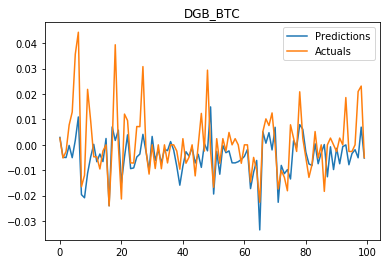

In [36]:
fig, ax = plt.subplots()
ax.plot(p.flatten(), label='Predictions')
ax.plot(targets.flatten(), label='Actuals')
ax.legend()
ax.set_title(dr.coin)
plt.show()
